# TRABAJO PRÁCTICO Nº 6

**Alumnos:**
- Nahuel Arrieta
- Lucas moyano

In [18]:
import sys
from skimage import io, color, measure
from skimage.color import label2rgb
from skimage.morphology import closing, footprint_rectangle
from skimage.filters import threshold_otsu
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def read_image(image_name):
    image_path = "./images/" + image_name

    # Read the image
    image = io.imread(image_path)   
    return image

In [20]:
def show_image(label, image):
  ## Create a plot
  plt.imshow(image, cmap='gray')
  plt.title(label)
  plt.axis('off')
  plt.show()

## Sección 1: Representaci´on y Descripci´on de Caracter´ısticas

### 2. (*) Representaci´on por relleno de regiones. Identificar los objetos en una imagen binaria y colorear cada regi´on detectada. Sugerencia: scikit-image: measure.label, regionprops, label2rgb.

In [21]:
## Apply the Otsu thresholding method
def apply_otsu_threshold(image):
    # Convert to grayscale if the image is RGB
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    
    # Apply Otsu's threshold
    thresh = threshold_otsu(image)
    binary = image > thresh
    
    return binary



In [22]:
def plot_regions(binary_image, colored_regions):
    """Muestra la imagen binaria original y las regiones coloreadas."""
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(binary_image, cmap='gray')
    plt.title("Imagen Binaria")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(colored_regions)
    plt.title("Regiones Coloreadas")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

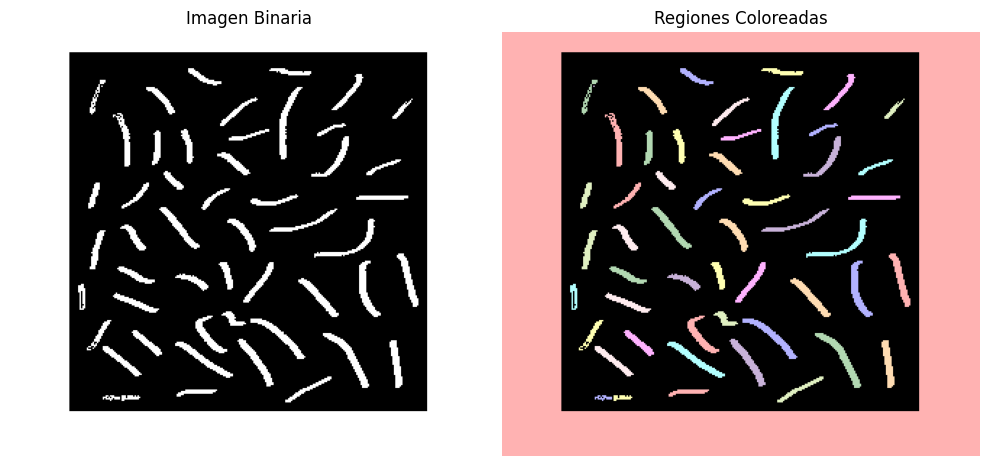

In [23]:
image = read_image("binary.png")
binary_image = apply_otsu_threshold(image)
label_image = measure.label(binary_image)
colored = label2rgb(label_image, image=binary_image, bg_label=0)
plot_regions(binary_image, colored)


### 4. (*) C´alculo de propiedades geom´etricas. Extraer ´area, per´ımetro, excentricidad y compacidad de cada regi´on segmentada. Sugerencia: regionprops de skimage.measure.

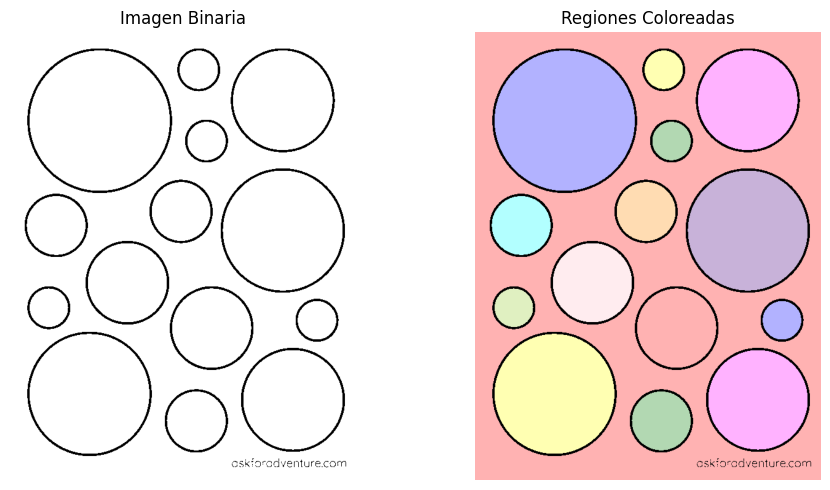

Región 1: Area=187418.0, Perimeter=9535.681092190353, Eccentricity=0.64, Compactness=485.17
Región 2: Area=40881.0, Perimeter=753.3523804664972, Eccentricity=0.03, Compactness=13.88
Región 3: Area=3067.0, Perimeter=203.8233764908628, Eccentricity=0.09, Compactness=13.55
Región 4: Area=20596.0, Perimeter=533.8721497261419, Eccentricity=0.04, Compactness=13.84
Región 5: Area=3066.0, Perimeter=203.8233764908628, Eccentricity=0.09, Compactness=13.55
Región 6: Area=29861.0, Perimeter=643.0264786586926, Eccentricity=0.05, Compactness=13.85
Región 7: Area=7182.0, Perimeter=314.14927829866735, Eccentricity=0.07, Compactness=13.74
Región 8: Area=7181.0, Perimeter=314.3919189857867, Eccentricity=0.05, Compactness=13.76
Región 9: Area=13007.0, Perimeter=422.47518010647184, Eccentricity=0.03, Compactness=13.72
Región 10: Area=3065.0, Perimeter=205.23759005323595, Eccentricity=0.07, Compactness=13.74
Región 11: Area=13017.0, Perimeter=424.71782079359116, Eccentricity=0.04, Compactness=13.86
Región 

In [24]:
image = read_image("circles.png")
binary_image = apply_otsu_threshold(image)
label_image = measure.label(binary_image)
colored = label2rgb(label_image, image=binary_image, bg_label=0)
plot_regions(binary_image, colored)

props = measure.regionprops(label_image)
for prop in props:
    area = prop.area
    perimeter = prop.perimeter
    eccentricity = prop.eccentricity
    compactness = (perimeter ** 2) / area if area > 0 else 0    
    
    print(f"Región {prop.label}: Area={area}, Perimeter={perimeter}, Eccentricity={eccentricity:.2f}, Compactness={compactness:.2f}")


### 6. (*) Descriptores de textura con GLCM. Calcular contraste, correlaci´on y homogeneidad de regiones usando matrices de co-ocurrencia. skimage.feature.greycomatrix, greycoprops.


In [25]:
from skimage.feature import graycomatrix, graycoprops
from skimage.util import img_as_ubyte

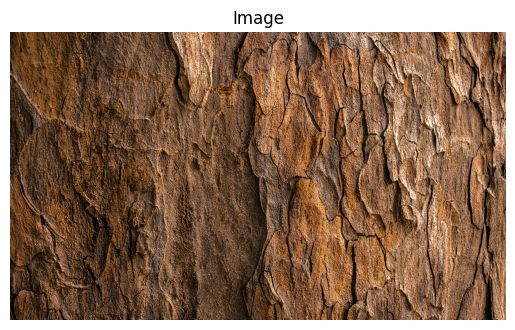

Contrast:     17806.4886
Correlation:  0.4394
Homogeneity:  0.7262


In [26]:
image = read_image("wood.png")
show_image("Image", image)
image = apply_otsu_threshold(image)
# Convert image to uint8
image_uint8 = img_as_ubyte(image)

# Compute the Gray-Level Co-occurrence Matrix (GLCM)
glcm = graycomatrix(image_uint8, 
                    distances=[1], 
                    angles=[0], 
                    levels=256,
                    symmetric=True, 
                    normed=True)

# Extract texture properties
contrast = graycoprops(glcm, 'contrast')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

# Print results
print(f"Contrast:     {contrast:.4f}")
print(f"Correlation:  {correlation:.4f}")
print(f"Homogeneity:  {homogeneity:.4f}")


### 8. (*) Relaci´on espacial entre regiones. Determinar si las regiones est´an adyacentes o si una est´a contenida en otra. skimage.measure.regionprops + an´alisis de coordenadas / bounding boxes.

In [27]:
from scipy.ndimage import binary_dilation


In [28]:
def check_containment(bbox1, bbox2):
    """Check if bbox2 is fully contained within bbox1."""
    return (bbox2[0] >= bbox1[0] and bbox2[1] >= bbox1[1] and
            bbox2[2] <= bbox1[2] and bbox2[3] <= bbox1[3])


In [29]:
def get_full_mask(region, image_shape):
    """Return a binary mask of the full image shape with the region placed correctly."""
    full_mask = np.zeros(image_shape, dtype=bool)
    minr, minc, maxr, maxc = region.bbox
    full_mask[minr:maxr, minc:maxc] = region.image
    return full_mask

def check_adjacency(mask1, mask2):
    """Check if two regions are adjacent using morphological dilation."""
    # Determine the maximum shape for padding
    max_rows = max(mask1.shape[0], mask2.shape[0])
    max_cols = max(mask1.shape[1], mask2.shape[1])

    # Pad both masks to the same shape
    padded_mask1 = np.zeros((max_rows, max_cols), dtype=bool)
    padded_mask2 = np.zeros((max_rows, max_cols), dtype=bool)

    padded_mask1[:mask1.shape[0], :mask1.shape[1]] = mask1
    padded_mask2[:mask2.shape[0], :mask2.shape[1]] = mask2

    # Dilate the first padded mask
    dilation_structure = np.ones((10, 10), dtype=bool)  # 3x3 square structuring element
    dilated1 = binary_dilation(padded_mask1, structure=dilation_structure)

    # Check for adjacency
    return np.any(dilated1 & padded_mask2)


Region 1 is adjacent to Region 2
Region 1 contains Region 6
Region 1 is adjacent to Region 7
Region 2 contains Region 4
Region 2 is adjacent to Region 7


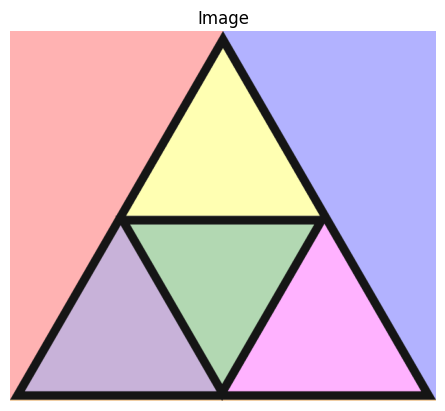

In [31]:
image = read_image("triangles.png")
binary_image = apply_otsu_threshold(image)

label_image = measure.label(binary_image)
props = measure.regionprops(label_image)

image_shape = image.shape[:2]
    

for i, prop1 in enumerate(props):
    for j, prop2 in enumerate(props):
        if i >= j:
            continue
        
        bbox1 = prop1.bbox
        bbox2 = prop2.bbox

        mask1 = get_full_mask(prop1, image_shape)
        mask2 = get_full_mask(prop2, image_shape)
        
        if check_containment(bbox1, bbox2):
            print(f"Region {prop1.label} contains Region {prop2.label}")
        elif check_containment(bbox2, bbox1):
            print(f"Region {prop2.label} contains Region {prop1.label}")

        elif check_adjacency(mask1, mask2):
            print(f"Region {prop1.label} is adjacent to Region {prop2.label}")

# Show the labeled image
show_image("Image", label2rgb(label_image, image=image, bg_label=0))
